In [1]:
using Plots 
using LinearAlgebra 
using Parameters 
using Statistics 

In [2]:
module My 

using Parameters 

@with_kw struct PhysicalParam
    d::Int64 = 5 # dimension 
end

end # module My

Main.My

In [3]:
param = My.PhysicalParam()

Main.My.PhysicalParam
  d: Int64 5


# Free energy

$$
    \beta F_{mf} 
    = - \frac{1}{2} d(d-1) \beta t(\lambda)^{4} 
    + d (\lambda - \beta H) t(\lambda) - d \ln c(\lambda)
$$
where 
\begin{align}
    c(\lambda) &= 
    \int dU \exp \left(\frac{\lambda}{N_{c}} 
    \mathrm{Re}\,\mathrm{Tr}\, U\right)
    \\
    t(\lambda) &= 
    c(\lambda)^{-1} \int dU \frac{1}{N_{c}} 
    \mathrm{Re}\,\mathrm{Tr}\, U
    \exp \left(\frac{\lambda}{N_{c}} 
    \mathrm{Re}\,\mathrm{Tr}\, U\right)
\end{align}

# 結合定数のベータ関数

$f = \ln (d_{F}^{-1} t(\beta))$に対し、

$$
    a \frac{df}{da}
    = \left(2 + (d-2) \beta \frac{\partial}{\partial \beta}\right) f
    = 2f + (d-2) \beta \frac{t'(\beta)}{t(\beta)}
$$

# $U(1)$

\begin{align}
    c(\lambda) 
    &= 
    \int_{-\pi}^{\pi}  \frac{d\theta}{2\pi}\, 
    e^{\lambda \cos \theta}
    \\
    t(\lambda)
    &= c(\lambda)^{-1}
    \int_{-\pi}^{\pi}  \frac{d\theta}{2\pi}\, 
    \cos \theta \, e^{\lambda \cos \theta}
\end{align}

In [4]:
function cosh_U1(λ; Nθ=100) 
    Δθ = 2π/Nθ
    c = 0.0
    for iθ in 1:Nθ
        θ = iθ*Δθ
        c += exp(λ*cos(θ))
    end
    c *= Δθ/2π
end

function tanh_U1(λ; Nθ=100)
    Δθ = 2π/Nθ
    t = 0.0
    for iθ in 1:Nθ
        θ = iθ*Δθ
        t += cos(θ)*exp(λ*cos(θ))
    end
    t *= (Δθ/2π)/cosh_U1(λ)
end

function tanh_deriv_U1(λ; Nθ=100)
    Δλ = 1e-2
    (tanh_U1(λ+Δλ; Nθ=Nθ) - tanh_U1(λ-Δλ; Nθ=Nθ))/2Δλ
end

tanh_deriv_U1 (generic function with 1 method)

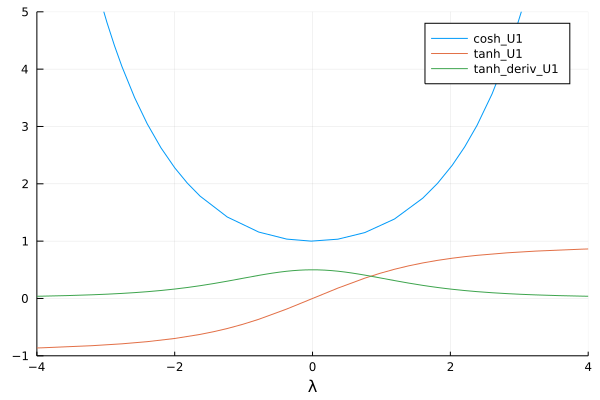

In [76]:
plot(xlim=(-4,4), ylim=(-1, 5), xlabel="λ")
plot!(cosh_U1; label="cosh_U1")
plot!(tanh_U1; label="tanh_U1")
plot!(tanh_deriv_U1; label="tanh_deriv_U1")

In [37]:
function gamma_U1(β, d)
    t  = tanh_U1(β)
    tp = tanh_deriv_U1(β)
    f  = log(t)
    
    -(2f*t/tp + (d-2)*β)
end

function plot_gamma_U1(;β_max=10)
    βs = range(0.1, β_max, step=0.1)
    p = plot(ylim=(-5, 5), xlim=(0, β_max), xlabel="β", ylabel="-a(dβ/da)")
    for d in 2:5
        f(β) = gamma_U1(β, d)
        plot!(p, βs, f.(βs); label="d = $d")
    end
    p
end

plot_gamma_U1 (generic function with 2 methods)

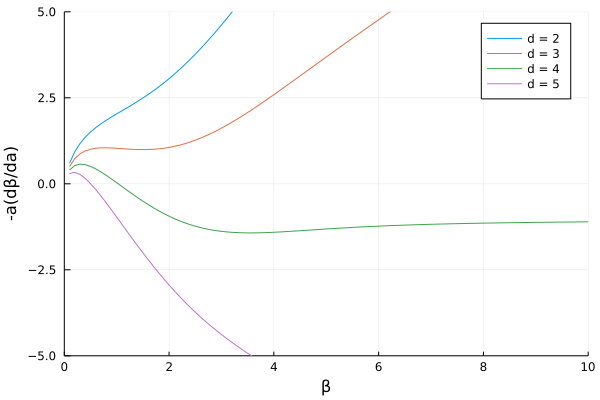

In [38]:
plot_gamma_U1(;β_max=10)

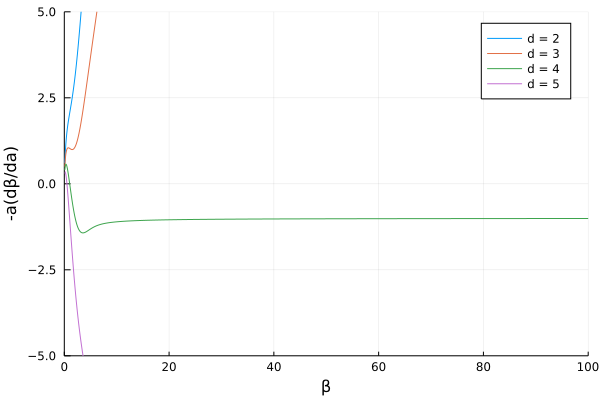

In [39]:
plot_gamma_U1(;β_max=100)

In [72]:
function free_energy_U1(param, λ, β)
    @unpack d = param 
    
    c = cosh_U1(λ)
    t = tanh_U1(λ)
    
    F  = -0.5d*(d-1)*β*t^4 + d*λ*t - d*log(c)
    F /= β
end

function test_free_energy_U1(param, βs; λ_max=10, λ_min=0)
    @unpack d = param
    λs = range(λ_min, λ_max, length=1000+1)
    Fs = zeros(Float64, length(λs))

    p = plot(title="U(1) in d=$d", xlabel="λ", ylabel="F", ylim=(-0.25, 1.0))
    for iβ in 1:length(βs)
        β = βs[iβ]
        f(λ) = free_energy_U1(param, λ, β)
        @time Fs .= f.(λs)
        plot!(p, λs, Fs; label="β = $(β)")
    end
    p
end

test_free_energy_U1 (generic function with 1 method)

  0.008177 seconds
  0.007945 seconds
  0.007935 seconds


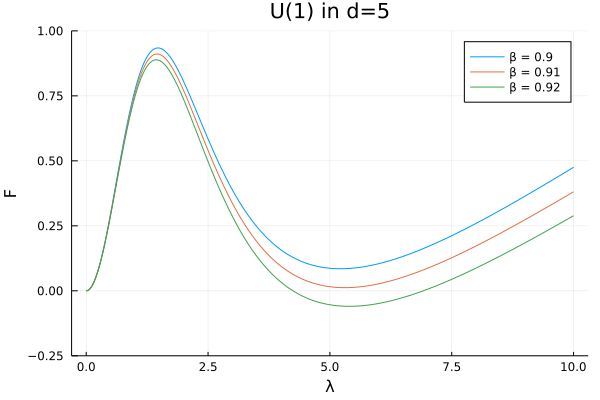

In [73]:
βs = [0.9, 0.91, 0.92]
test_free_energy_U1(param, βs; λ_max=10)

# $ SU(2) $

\begin{align}
    c(\lambda) 
    &= \frac{2}{\pi} \int_{-1}^{1} da_{0} 
    \sqrt{1 - a_{0}^{2}} \, e^{\lambda a_{0}}
    \\
    t(\lambda)
    &= c(\lambda)^{-1} \frac{2}{\pi} \int_{-1}^{1} da_{0} 
    \sqrt{1 - a_{0}^{2}} \, a_{0} \, e^{\lambda a_{0}}
\end{align}

In [18]:
function cosh_SU2(λ; Na₀=1000)
    Δa₀ = 2/Na₀
    f(a₀) = sqrt(1 - a₀*a₀)*exp(λ*a₀)
    
    c = 0.5(f(-1) + f(1))
    for ia₀ in 1:Na₀-1
        c += f(ia₀*Δa₀ - 1)
    end
    c *= 2Δa₀/π
end

function tanh_SU2(λ; Na₀=1000)
    Δa₀ = 2/Na₀
    f(a₀) = sqrt(1 - a₀*a₀)*a₀*exp(λ*a₀)
    
    t = 0.5(f(-1) + f(1))
    for ia₀ in 1:Na₀-1
        t += f(ia₀*Δa₀ - 1)
    end
    t *= (2Δa₀/π)/cosh_SU2(λ)
end

function tanh_deriv_SU2(λ; Na₀=1000)
    Δλ = 1e-2
    (tanh_SU2(λ+Δλ; Na₀=Na₀) - tanh_SU2(λ-Δλ; Na₀=Na₀))/2Δλ
end

tanh_deriv_SU2 (generic function with 1 method)

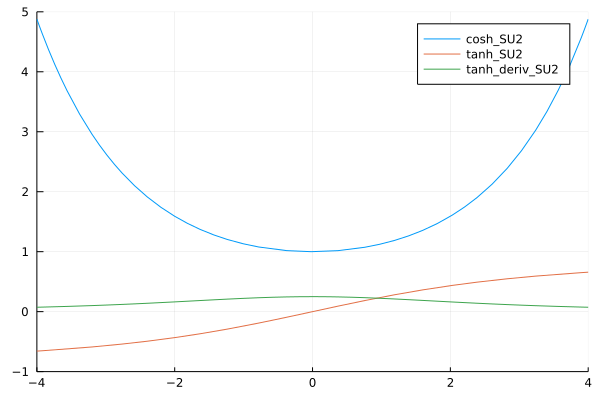

In [75]:
plot(xlim=(-4,4), ylim=(-1, 5))
plot!(cosh_SU2; label="cosh_SU2")
plot!(tanh_SU2; label="tanh_SU2")
plot!(tanh_deriv_SU2; label="tanh_deriv_SU2")

In [34]:
function gamma_SU2(β, d)
    t  = tanh_SU2(β)
    tp = tanh_deriv_SU2(β)
    f  = log(t)
    
    -(2f*t/tp + (d-2)*β)
end

function plot_gamma_SU2(;β_max=10)
    βs = range(0.1, β_max, step=0.1)
    p = plot(ylim=(-5, 5), xlim=(0, β_max), xlabel="β", ylabel="-a(dβ/da)")
    for d in 2:5
        f(β) = gamma_SU2(β, d)
        plot!(p, βs, f.(βs); label="d = $d")
    end
    p
end

plot_gamma_SU2 (generic function with 1 method)

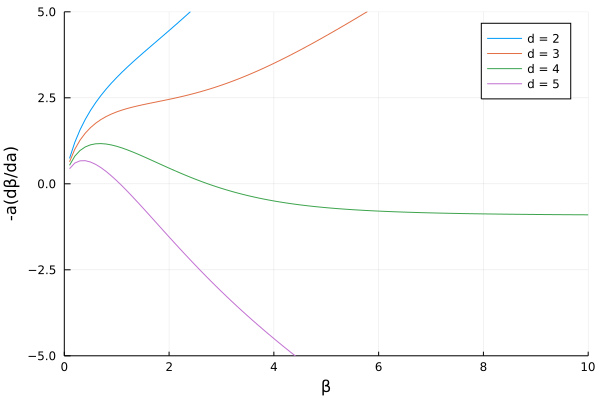

In [35]:
plot_gamma_SU2(;β_max=10)

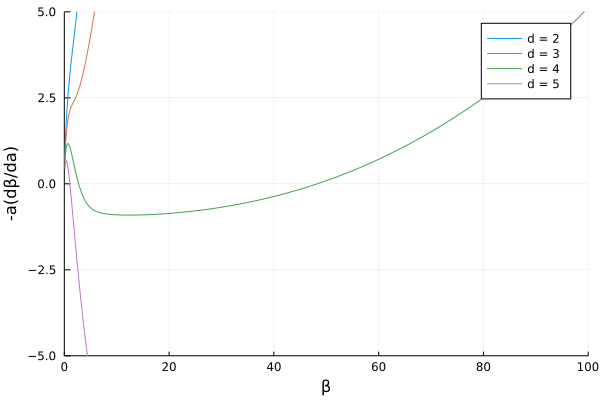

In [36]:
plot_gamma_SU2(;β_max=100)

In [70]:
function free_energy_SU2(param, λ, β)
    @unpack d = param 
    
    c = cosh_SU2(λ)
    t = tanh_SU2(λ)
    
    F  = -0.5d*(d-1)*β*t^4 + d*λ*t - d*log(c)
    F /= β
end

function test_free_energy_SU2(param, βs; λ_max=10, λ_min=0)
    @unpack d = param
    λs = range(λ_min, λ_max, length=1000+1)
    Fs = zeros(Float64, length(λs))

    p = plot(title="SU(2) in d=$d", xlabel="λ", ylabel="F", ylim=(-0.25,1))
    for iβ in 1:length(βs)
        β = βs[iβ]
        f(λ) = free_energy_SU2(param, λ, β)
        @time Fs .= f.(λs)
        plot!(p, λs, Fs; label="β = $(β)")
    end
    p
end

test_free_energy_SU2 (generic function with 1 method)

  0.029717 seconds
  0.029987 seconds
  0.030709 seconds


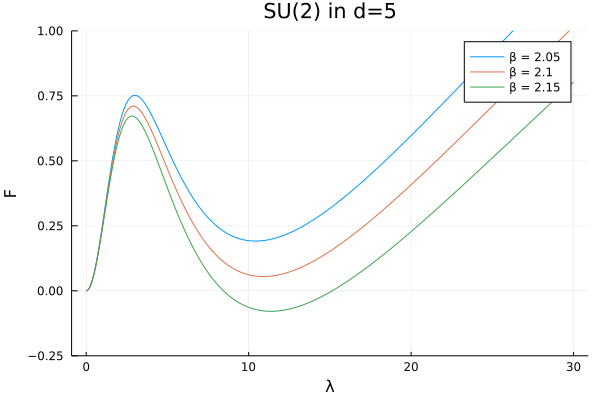

In [71]:
βs = [2.05, 2.1, 2.15]
test_free_energy_SU2(param, βs; λ_max=30)

# $SU(3)$